# Poisson-Boltzmann Equation (nonlinear)

A result for dimension 10. 

$$
\begin{cases}
\triangle u = \sinh u + f & x \in \Omega \\
u = g & x \in \partial \Omega
\end{cases}
$$
where 
$$
\Omega = \{x \in {\mathbb R}^{D}: \|x\|_{2} \leq L\}
$$
we construct the true solution as 
$$
u = \alpha \sum_{i=1}^D x_i ^2
$$
so we have

$$
g \equiv \alpha L^2
$$

$$
f = 2\alpha D - \sinh \left( \alpha \sum_{i=1}^D x_i^2 \right)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, vmap
from time import time

import math, os, sys
torch.manual_seed(0)

In [2]:
# dimension
D = 10

# domain width
L = 1.0

In [3]:
# rhs

alph = 2.


def f(x):
    return -x.sin().sum() - x.sin().sum().sinh()
    # return 2 * alph * D - (x.square().sum()) ** 2


# boundary condition
def g(x):
    return x.sin().sum()


def u_true(x):
    return x.sin().sum()

In [4]:
# path simulation time
T = 0.25

# Total umber of paths
M_tot = 100000

# Batch size of each epoch
M = 4000

# number of grid points
N = 25

# number of grid points at the boundaries
N_bdry = 2000

# number of collocation points for evaluating the integral
N_test = 100

# number of training epochs
n_epoch = 3000

In [5]:
# time step size
dt = T / N
dBt = math.sqrt(dt)

def sample_NDstdBM_paths(M: int, D: int, T: float, N: int):
    return torch.cumsum(
        torch.concat([
            torch.zeros(M, 1, D),
            torch.randn(M, N, D) * math.sqrt(T / N)
        ], dim=1), dim=1
    )


W_tot = sample_NDstdBM_paths(M_tot, D, T, N)

In [6]:
def mask_NDstdBM_paths(paths, L: float):
    oob = paths.square().sum(dim=2).le(L ** 2).double()
    return oob.cummin(dim=1).values, oob.argmin(dim=1)


mask, exit_idx = mask_NDstdBM_paths(W_tot, L)
print(f"Boundary unreached rate: {mask[:, -1].sum().item() / M_tot * 100:.2f}%")

Boundary unreached rate: 1.32%


In [7]:
def sample_boundary_points(N_bdry: int, D: int, L: float):
    rand_n = torch.randn(N_bdry, D)
    return rand_n / rand_n.square().sum(dim=1).sqrt().unsqueeze(dim=1) * L


X_bdry = sample_boundary_points(N_bdry, D, L)

In [8]:
u = nn.Sequential(nn.Linear(D, 20),
                  nn.Tanh(), # nn.GELU(approximate="tanh"),
                  nn.Linear(20, 40),
                  nn.Tanh(), # nn.GELU(approximate="tanh"),
                  nn.Linear(40, 10),
                  nn.Tanh(), # nn.GELU(approximate="tanh"),
                  nn.Linear(10, 1))

X_test = torch.randn(N_test, D)
X_test = X_test / X_test.norm(dim=1).unsqueeze(dim=1) * torch.rand(N_test, 1) * L

optimizer = torch.optim.Adamax(u.parameters(), lr=.05, )

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

loss_rec = np.zeros(n_epoch + 1)
l2_err_rec = np.zeros(n_epoch + 1)
l2_norm_rec = np.zeros(n_epoch + 1)

f_val_tot = vmap(vmap(f))(W_tot)
g_val = vmap(g)(X_bdry)

In [9]:
start_time = time()
use_different_boundary_points_for_each_epoch = True
u_saved = u
min_loss = 1e+50
for i in range(n_epoch):
    batch_idx = torch.randint(0, M_tot, (M,))
    W = W_tot[batch_idx]
    f_val = f_val_tot[batch_idx]
    u_val = vmap(u)(W).squeeze()
    u_val_bdry = u(X_bdry).squeeze()
    loss_mart = ((u_val[:, 1:] - u_val[:, :-1] - (f_val + torch.sinh(u_val))[:, :-1] / 2. * dt)
                 * mask[batch_idx, :-1]).sum(axis=0).pow(2).sum() / T / M ** 2
    # loss_mart = ((u_val[:, 1:] - u_val[:, :-1] - (f_val + u_val ** 2)[:, :-1] / 2. * dt)
    #              * mask[batch_idx, :-1]).sum(axis=0).pow(2).sum() / T / M ** 2
    if use_different_boundary_points_for_each_epoch:
        X_bdry = sample_boundary_points(N_bdry, D, L)
        loss_bdry = (u(X_bdry).squeeze() - vmap(g)(X_bdry)).pow(2).sum() / N_bdry
    else:
        loss_bdry = (u(X_bdry).squeeze() - g_val).pow(2).sum() / N_bdry
    loss = loss_mart + 5000 * loss_bdry#  + 100 * u(torch.zeros(1, D)) ** 2
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if min_loss > loss.item():
        min_loss = loss.item()
        u_saved = u

    # u_test_val = u(X_test).squeeze()
    # u_true_val = vmap(u_true)(X_test).squeeze()
    # L2_loss = torch.sqrt((u_test_val - u_true_val).pow(2).sum() / N_test)
    # L2_norm = torch.sqrt(u_test_val.pow(2).sum() / N_test)

    loss_rec[i] = loss.item()

    u_test_val = u(X_test).squeeze()
    u_true_val = vmap(u_true)(X_test).squeeze()
    L2_loss = torch.sqrt((u_test_val - u_true_val).pow(2).sum() / N_test)
    L2_norm = torch.sqrt(u_test_val.pow(2).sum() / N_test)
    l2_err_rec[i] = L2_loss.item()
    l2_norm_rec[i] = L2_norm.item()
    
    if i % 100 == 0:
        scheduler.step()
    
    if i % 100 == 0 or i == n_epoch - 1:
        print(f"round {i}, loss={loss.item()}, L2 error={L2_loss.item()}, L2 norm={L2_norm.item()}")

end_time = time()

print(f"Training finished in {end_time - start_time} seconds.")
print("Now saving the results ... ", end="")
torch.save(u.state_dict(), os.path.join(".", "the_network.pt"))
np.savez("loss_and_err.npz", loss_rec=loss_rec, l2_err_rec=l2_err_rec)
print("done.")
print("Congratulations! Everything is done.")

round 0, loss=4332.250983168978, L2 error=0.5105013251304626, L2 norm=0.32524973154067993
round 100, loss=23.16873913039328, L2 error=0.029160724952816963, L2 norm=0.5007011294364929
round 200, loss=5.838297940675866, L2 error=0.016764923930168152, L2 norm=0.4901794493198395
round 300, loss=5.280515541261796, L2 error=0.016485102474689484, L2 norm=0.4908543825149536
round 400, loss=4.452489600132777, L2 error=0.015088533982634544, L2 norm=0.49195730686187744
round 500, loss=4.505983868910402, L2 error=0.015630904585123062, L2 norm=0.49065130949020386
round 600, loss=4.083210490991414, L2 error=0.014637419022619724, L2 norm=0.49182191491127014
round 700, loss=3.7113334173036203, L2 error=0.01474109198898077, L2 norm=0.491321861743927
round 800, loss=3.8786207128796746, L2 error=0.014544842764735222, L2 norm=0.4920635223388672
round 900, loss=3.466486367146341, L2 error=0.014611533842980862, L2 norm=0.49187350273132324
round 1000, loss=3.573152428444021, L2 error=0.014522361569106579, L2

In [10]:
"""
x_test = torch.linspace(-L, L, 100).unsqueeze(dim=1) * torch.ones(D)
u_test = u(x_test)
u_test_true = vmap(u_true)(x_test)
plt.plot(np.linspace(-L, L, 100).unsqueeze(dim=1) * , u_test.detach().numpy().flatten())
plt.plot(np.linspace(-L, L, 100), u_test_true.detach().numpy().flatten())
plt.show()
"""

'\nx_test = torch.linspace(-L, L, 100).unsqueeze(dim=1) * torch.ones(D)\nu_test = u(x_test)\nu_test_true = vmap(u_true)(x_test)\nplt.plot(np.linspace(-L, L, 100).unsqueeze(dim=1) * , u_test.detach().numpy().flatten())\nplt.plot(np.linspace(-L, L, 100), u_test_true.detach().numpy().flatten())\nplt.show()\n'

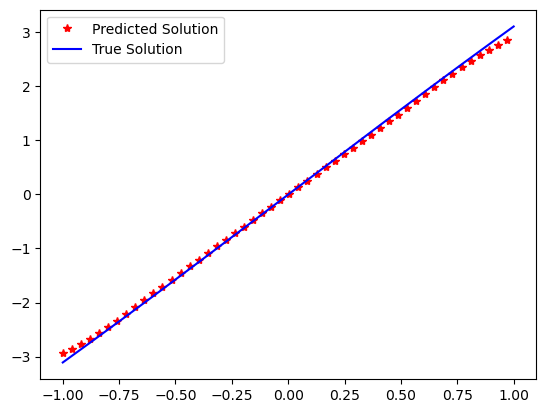

In [11]:
u.load_state_dict(torch.load("the_network.pt"))

x_test = torch.linspace(-L / np.sqrt(D), L / np.sqrt(D), 200).unsqueeze(dim=1) * torch.tensor([1.] * D).type(torch.float)
plt.plot(np.linspace(-L, L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "r*")
plt.plot(np.linspace(-L, L, 200), vmap(u_true)(x_test).detach().numpy(), "b")
# plt.ylim(0.99, 1.01)
plt.legend(["Predicted Solution", "True Solution"])
plt.savefig("100d_diag.png")
plt.show()

$$
u(x \mathbf{e}), x \in [-L, L]
$$
where
$$
\mathbf{e} = \frac{1}{\sqrt{D}} (1, 1, \cdots, 1)
$$

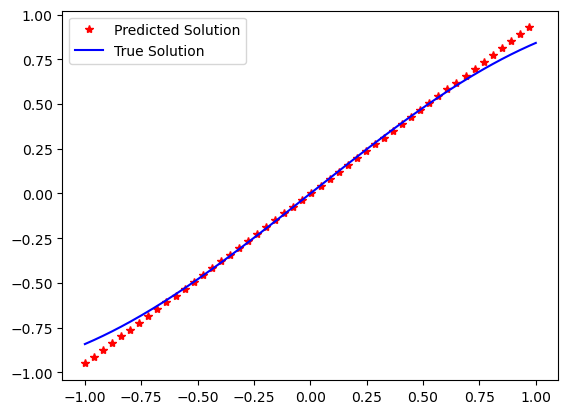

In [12]:
x_test = torch.linspace(-1, 1, 200).unsqueeze(dim=1) * (torch.tensor([1.] + [0.] * (D-1)))

plt.plot(np.linspace(-L, L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "r*")
plt.plot(np.linspace(-L, L, 200), vmap(u_true)(x_test).detach().numpy(), "b")
# plt.ylim(90, 105)
plt.legend(["Predicted Solution", "True Solution"])
plt.savefig("100d_axis.png")
plt.show()

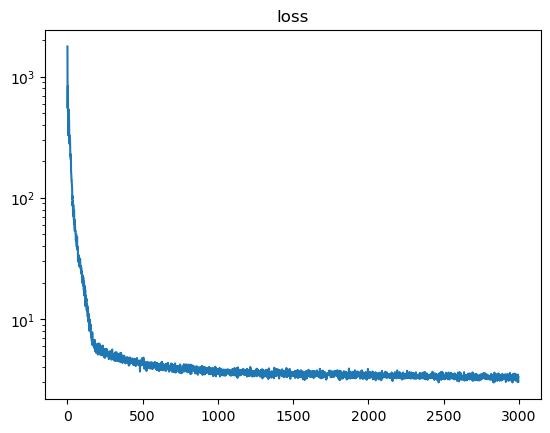

In [13]:
rec = np.load("loss_and_err.npz")
l2_err_rec = rec["l2_err_rec"]
loss_rec = rec["loss_rec"]

plt.semilogy(loss_rec[2:-1])
plt.title("loss")
plt.show()

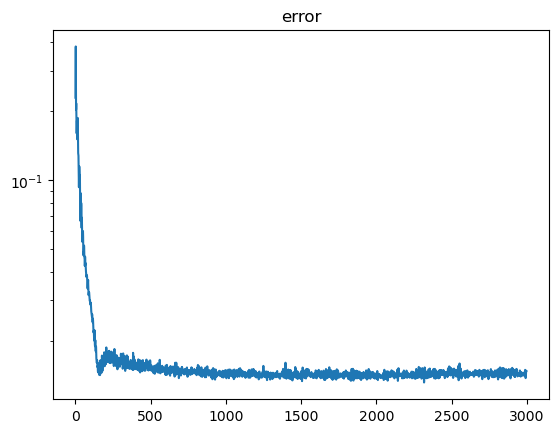

In [14]:
plt.semilogy(l2_err_rec[2:-1])
plt.title("error")
plt.show()